# Model Performance Comparison

**Gold Price Prediction Models: ARIMA, XGBoost, Random Forest, LightGBM**

This notebook compares the performance of all trained models using:
- **RMSE** (Root Mean Squared Error) - absolute and percentage
- **MAPE** (Mean Absolute Percentage Error) - percentage error
- **MAE** (Mean Absolute Error) - absolute and percentage

All models are evaluated on the same test dataset with a 3-year rolling window.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import joblib
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Get project root directory (parent of models folder)
if Path.cwd().name == 'models':
    project_root = Path.cwd().parent
else:
    project_root = Path.cwd()

# Add project root to path for imports
sys.path.insert(0, str(project_root))

from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from pipelines.feature_engineering_optimized import create_optimized_features

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print(f"Project root: {project_root}")
print("Libraries imported successfully")


Project root: /Users/feepieper/Desktop/capstone_projects/ML_model_gold_price_predictions
Libraries imported successfully


In [2]:
# Load data and prepare for evaluation
data_path = project_root / "gold_GCF_10y_1d.csv"
df = pd.read_csv(data_path)

if "Date" in df.columns:
    df = df.set_index("Date")
elif "datetime" in df.columns:
    df = df.set_index("datetime")
else:
    df = df.set_index(df.columns[0])

df.index = pd.to_datetime(df.index)
df = df.sort_index()

# Apply 3-year rolling window (same as training)
ROLLING_YEARS = 3
cutoff = df.index.max() - pd.Timedelta(days=ROLLING_YEARS * 365)
df_3y = df[df.index >= cutoff].copy()

print(f"Data loaded: {len(df_3y)} trading days")
print(f"Date range: {df_3y.index.min().strftime('%Y-%m-%d')} to {df_3y.index.max().strftime('%Y-%m-%d')}")
print(f"Mean price: ${df_3y['close'].mean():.2f}/oz")
print(f"Price range: ${df_3y['close'].min():.2f} - ${df_3y['close'].max():.2f}")


Data loaded: 754 trading days
Date range: 2022-12-12 to 2025-12-10
Mean price: $2547.43/oz
Price range: $1777.20 - $4336.40


In [3]:
# Split data: 80% train, 20% test (same as training scripts)
split_idx = int(len(df_3y) * 0.8)
train_data = df_3y.iloc[:split_idx].copy()
test_data = df_3y.iloc[split_idx:].copy()

print(f"Training set: {len(train_data)} days ({train_data.index.min().strftime('%Y-%m-%d')} to {train_data.index.max().strftime('%Y-%m-%d')})")
print(f"Test set: {len(test_data)} days ({test_data.index.min().strftime('%Y-%m-%d')} to {test_data.index.max().strftime('%Y-%m-%d')})")
print(f"\nTest set price range: ${test_data['close'].min():.2f} - ${test_data['close'].max():.2f}")
print(f"Test set mean price: ${test_data['close'].mean():.2f}/oz")


Training set: 603 days (2022-12-12 to 2025-05-07)
Test set: 151 days (2025-05-08 to 2025-12-10)

Test set price range: $3181.40 - $4336.40
Test set mean price: $3633.34/oz


In [4]:
# Define evaluation metrics
def calculate_metrics(y_true, y_pred, model_name="Model"):
    """
    Calculate RMSE, MAE, and MAPE metrics.
    Returns both absolute and percentage values.
    """
    # Remove any NaN values
    mask = ~(np.isnan(y_true) | np.isnan(y_pred))
    y_true_clean = np.array(y_true)[mask]
    y_pred_clean = np.array(y_pred)[mask]
    
    if len(y_true_clean) == 0:
        return {
            'rmse_abs': np.inf,
            'mae_abs': np.inf,
            'mape': np.inf,
            'rmse_pct': np.inf,
            'mae_pct': np.inf,
            'n_samples': 0
        }
    
    # Absolute metrics
    rmse_abs = np.sqrt(mean_squared_error(y_true_clean, y_pred_clean))
    mae_abs = mean_absolute_error(y_true_clean, y_pred_clean)
    
    # Percentage metrics
    mean_price = np.mean(y_true_clean)
    rmse_pct = (rmse_abs / mean_price) * 100
    mae_pct = (mae_abs / mean_price) * 100
    
    # MAPE (Mean Absolute Percentage Error)
    mape = np.mean(np.abs((y_true_clean - y_pred_clean) / y_true_clean)) * 100
    
    return {
        'rmse_abs': rmse_abs,
        'mae_abs': mae_abs,
        'mape': mape,
        'rmse_pct': rmse_pct,
        'mae_pct': mae_pct,
        'n_samples': len(y_true_clean),
        'mean_price': mean_price
    }

print("Evaluation functions defined")


Evaluation functions defined


In [5]:
# 1. ARIMA Model Evaluation
print("="*60)
print("1. ARIMA MODEL EVALUATION")
print("="*60)

ARIMA_ORDER = (3, 1, 3)
arima_results = {'day': {}, 'week': {}}

# Rolling forecast for next day
print("\nEvaluating ARIMA for Next Day prediction...")
history = train_data['close'].copy()
preds_day = []
test_day_actual = []

for i in range(len(test_data)):
    if len(history) < 10:
        break
    try:
        model = ARIMA(history, order=ARIMA_ORDER)
        res = model.fit()
        fc = res.forecast(steps=1)
        preds_day.append(fc.iloc[0])
        test_day_actual.append(test_data['close'].iloc[i])
        history = pd.concat([history, test_data['close'].iloc[i:i+1]])
    except Exception as e:
        print(f"Warning: ARIMA forecast failed at step {i}: {e}")
        break

if len(preds_day) > 0:
    arima_results['day'] = calculate_metrics(test_day_actual, preds_day, "ARIMA-Day")
    print(f"  Next Day - RMSE: ${arima_results['day']['rmse_abs']:.2f} ({arima_results['day']['rmse_pct']:.2f}%)")
    print(f"            MAE:  ${arima_results['day']['mae_abs']:.2f} ({arima_results['day']['mae_pct']:.2f}%)")
    print(f"            MAPE: {arima_results['day']['mape']:.2f}%")

# Rolling forecast for next week (5 trading days)
print("\nEvaluating ARIMA for Next Week prediction...")
history = train_data['close'].copy()
preds_week = []
test_week_actual = []

for i in range(len(test_data)):
    if len(history) < 10:
        break
    try:
        model = ARIMA(history, order=ARIMA_ORDER)
        res = model.fit()
        fc = res.forecast(steps=5)
        preds_week.append(fc.iloc[-1])  # 5th day forecast
        test_week_actual.append(test_data['close'].iloc[min(i+4, len(test_data)-1)])
        history = pd.concat([history, test_data['close'].iloc[i:i+1]])
    except Exception as e:
        break

if len(preds_week) > 0:
    arima_results['week'] = calculate_metrics(test_week_actual, preds_week, "ARIMA-Week")
    print(f"  Next Week - RMSE: ${arima_results['week']['rmse_abs']:.2f} ({arima_results['week']['rmse_pct']:.2f}%)")
    print(f"             MAE:  ${arima_results['week']['mae_abs']:.2f} ({arima_results['week']['mae_pct']:.2f}%)")
    print(f"             MAPE: {arima_results['week']['mape']:.2f}%")


1. ARIMA MODEL EVALUATION

Evaluating ARIMA for Next Day prediction...


/opt/anaconda3/envs/ai_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/ai_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/ai_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/ai_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

  Next Day - RMSE: $50.32 (1.39%)
            MAE:  $36.07 (0.99%)
            MAPE: 0.98%

Evaluating ARIMA for Next Week prediction...


/opt/anaconda3/envs/ai_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/ai_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/ai_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/ai_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.

  Next Week - RMSE: $100.61 (2.75%)
             MAE:  $77.18 (2.11%)
             MAPE: 2.07%


/opt/anaconda3/envs/ai_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [6]:
# 2. XGBoost Model Evaluation
print("\n" + "="*60)
print("2. XGBOOST MODEL EVALUATION")
print("="*60)

# Load XGBoost models
model_dir_xgb = project_root / "models" / "model_xgb"
xgb_results = {'day': {}, 'week': {}}

try:
    model_day_xgb = joblib.load(model_dir_xgb / "model_day.pkl")
    model_week_xgb = joblib.load(model_dir_xgb / "model_week.pkl")
    scaler_day_xgb = joblib.load(model_dir_xgb / "scaler_day.pkl")
    scaler_week_xgb = joblib.load(model_dir_xgb / "scaler_week.pkl")
    feats_day_xgb = joblib.load(model_dir_xgb / "features_day.pkl")
    feats_week_xgb = joblib.load(model_dir_xgb / "features_week.pkl")
    
    # Prepare test data with features
    test_feats = create_optimized_features(test_data.copy())
    
    # Next Day predictions
    X_test_day = test_feats[feats_day_xgb]
    X_test_day_scaled = scaler_day_xgb.transform(X_test_day)
    preds_day_xgb = model_day_xgb.predict(X_test_day_scaled)
    actual_day = test_data['close'].values[:len(preds_day_xgb)]
    
    xgb_results['day'] = calculate_metrics(actual_day, preds_day_xgb, "XGBoost-Day")
    print(f"\n  Next Day - RMSE: ${xgb_results['day']['rmse_abs']:.2f} ({xgb_results['day']['rmse_pct']:.2f}%)")
    print(f"            MAE:  ${xgb_results['day']['mae_abs']:.2f} ({xgb_results['day']['mae_pct']:.2f}%)")
    print(f"            MAPE: {xgb_results['day']['mape']:.2f}%")
    
    # Next Week predictions
    X_test_week = test_feats[feats_week_xgb]
    X_test_week_scaled = scaler_week_xgb.transform(X_test_week)
    preds_week_xgb = model_week_xgb.predict(X_test_week_scaled)
    actual_week = test_data['close'].values[:len(preds_week_xgb)]
    
    xgb_results['week'] = calculate_metrics(actual_week, preds_week_xgb, "XGBoost-Week")
    print(f"\n  Next Week - RMSE: ${xgb_results['week']['rmse_abs']:.2f} ({xgb_results['week']['rmse_pct']:.2f}%)")
    print(f"             MAE:  ${xgb_results['week']['mae_abs']:.2f} ({xgb_results['week']['mae_pct']:.2f}%)")
    print(f"             MAPE: {xgb_results['week']['mape']:.2f}%")
    
except Exception as e:
    print(f"Error loading XGBoost models: {e}")
    import traceback
    traceback.print_exc()



2. XGBOOST MODEL EVALUATION

  Next Day - RMSE: $395.71 (11.18%)
            MAE:  $309.88 (8.76%)
            MAPE: 8.30%

  Next Week - RMSE: $417.12 (11.79%)
             MAE:  $294.11 (8.31%)
             MAPE: 7.73%


In [7]:
# 3. Random Forest Model Evaluation
print("\n" + "="*60)
print("3. RANDOM FOREST MODEL EVALUATION")
print("="*60)

model_dir_rf = project_root / "models" / "model_rf"
rf_results = {'day': {}, 'week': {}}

try:
    model_day_rf = joblib.load(model_dir_rf / "model_day.pkl")
    model_week_rf = joblib.load(model_dir_rf / "model_week.pkl")
    scaler_day_rf = joblib.load(model_dir_rf / "scaler_day.pkl")
    scaler_week_rf = joblib.load(model_dir_rf / "scaler_week.pkl")
    feats_day_rf = joblib.load(model_dir_rf / "features_day.pkl")
    feats_week_rf = joblib.load(model_dir_rf / "features_week.pkl")
    
    # Prepare test data with features
    test_feats = create_optimized_features(test_data.copy())
    
    # Next Day predictions
    X_test_day = test_feats[feats_day_rf]
    X_test_day_scaled = scaler_day_rf.transform(X_test_day)
    preds_day_rf = model_day_rf.predict(X_test_day_scaled)
    actual_day = test_data['close'].values[:len(preds_day_rf)]
    
    rf_results['day'] = calculate_metrics(actual_day, preds_day_rf, "RF-Day")
    print(f"\n  Next Day - RMSE: ${rf_results['day']['rmse_abs']:.2f} ({rf_results['day']['rmse_pct']:.2f}%)")
    print(f"            MAE:  ${rf_results['day']['mae_abs']:.2f} ({rf_results['day']['mae_pct']:.2f}%)")
    print(f"            MAPE: {rf_results['day']['mape']:.2f}%")
    
    # Next Week predictions
    X_test_week = test_feats[feats_week_rf]
    X_test_week_scaled = scaler_week_rf.transform(X_test_week)
    preds_week_rf = model_week_rf.predict(X_test_week_scaled)
    actual_week = test_data['close'].values[:len(preds_week_rf)]
    
    rf_results['week'] = calculate_metrics(actual_week, preds_week_rf, "RF-Week")
    print(f"\n  Next Week - RMSE: ${rf_results['week']['rmse_abs']:.2f} ({rf_results['week']['rmse_pct']:.2f}%)")
    print(f"             MAE:  ${rf_results['week']['mae_abs']:.2f} ({rf_results['week']['mae_pct']:.2f}%)")
    print(f"             MAPE: {rf_results['week']['mape']:.2f}%")
    
except Exception as e:
    print(f"Error loading Random Forest models: {e}")
    import traceback
    traceback.print_exc()



3. RANDOM FOREST MODEL EVALUATION

  Next Day - RMSE: $375.28 (10.61%)
            MAE:  $254.85 (7.20%)
            MAPE: 6.66%

  Next Week - RMSE: $403.89 (11.42%)
             MAE:  $288.49 (8.15%)
             MAPE: 7.59%


In [14]:
# 4. LightGBM Model Evaluation
print("\n" + "="*60)
print("4. LIGHTGBM MODEL EVALUATION")
print("="*60)

model_dir_lgbm = project_root / "models" / "model_lgbm"
lgbm_results = {'day': {}, 'week': {}}

try:
    model_day_lgbm = joblib.load(model_dir_lgbm / "model_day.pkl")
    model_week_lgbm = joblib.load(model_dir_lgbm / "model_week.pkl")
    scaler_day_lgbm = joblib.load(model_dir_lgbm / "scaler_day.pkl")
    scaler_week_lgbm = joblib.load(model_dir_lgbm / "scaler_week.pkl")
    feats_day_lgbm = joblib.load(model_dir_lgbm / "features_day.pkl")
    feats_week_lgbm = joblib.load(model_dir_lgbm / "features_week.pkl")
    
    # Prepare test data with features
    test_feats = create_optimized_features(test_data.copy())
    
    # Next Day predictions
    X_test_day = test_feats[feats_day_lgbm]
    X_test_day_scaled = scaler_day_lgbm.transform(X_test_day)
    preds_day_lgbm = model_day_lgbm.predict(X_test_day_scaled)
    actual_day = test_data['close'].values[:len(preds_day_lgbm)]
    
    lgbm_results['day'] = calculate_metrics(actual_day, preds_day_lgbm, "LightGBM-Day")
    print(f"\n  Next Day - RMSE: ${lgbm_results['day']['rmse_abs']:.2f} ({lgbm_results['day']['rmse_pct']:.2f}%)")
    print(f"            MAE:  ${lgbm_results['day']['mae_abs']:.2f} ({lgbm_results['day']['mae_pct']:.2f}%)")
    print(f"            MAPE: {lgbm_results['day']['mape']:.2f}%")
    
    # Next Week predictions
    X_test_week = test_feats[feats_week_lgbm]
    X_test_week_scaled = scaler_week_lgbm.transform(X_test_week)
    preds_week_lgbm = model_week_lgbm.predict(X_test_week_scaled)
    actual_week = test_data['close'].values[:len(preds_week_lgbm)]
    
    lgbm_results['week'] = calculate_metrics(actual_week, preds_week_lgbm, "LightGBM-Week")
    print(f"\n  Next Week - RMSE: ${lgbm_results['week']['rmse_abs']:.2f} ({lgbm_results['week']['rmse_pct']:.2f}%)")
    print(f"             MAE:  ${lgbm_results['week']['mae_abs']:.2f} ({lgbm_results['week']['mae_pct']:.2f}%)")
    print(f"             MAPE: {lgbm_results['week']['mape']:.2f}%")
    
except Exception as e:
    print(f"Error loading LightGBM models: {e}")
    import traceback
    traceback.print_exc()



4. LIGHTGBM MODEL EVALUATION

  Next Day - RMSE: $392.41 (11.09%)
            MAE:  $297.27 (8.40%)
            MAPE: 7.91%

  Next Week - RMSE: $379.93 (10.74%)
             MAE:  $249.74 (7.06%)
             MAPE: 6.49%


In [15]:
# Compile all results into comparison tables
print("\n" + "="*60)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*60)

# Create comparison DataFrame for Next Day
comparison_day = pd.DataFrame({
    'ARIMA': [
        arima_results['day'].get('rmse_abs', np.nan),
        arima_results['day'].get('mae_abs', np.nan),
        arima_results['day'].get('mape', np.nan),
        arima_results['day'].get('rmse_pct', np.nan),
        arima_results['day'].get('mae_pct', np.nan)
    ],
    'XGBoost': [
        xgb_results['day'].get('rmse_abs', np.nan),
        xgb_results['day'].get('mae_abs', np.nan),
        xgb_results['day'].get('mape', np.nan),
        xgb_results['day'].get('rmse_pct', np.nan),
        xgb_results['day'].get('mae_pct', np.nan)
    ],
    'Random Forest': [
        rf_results['day'].get('rmse_abs', np.nan),
        rf_results['day'].get('mae_abs', np.nan),
        rf_results['day'].get('mape', np.nan),
        rf_results['day'].get('rmse_pct', np.nan),
        rf_results['day'].get('mae_pct', np.nan)
    ],
    'LightGBM': [
        lgbm_results['day'].get('rmse_abs', np.nan),
        lgbm_results['day'].get('mae_abs', np.nan),
        lgbm_results['day'].get('mape', np.nan),
        lgbm_results['day'].get('rmse_pct', np.nan),
        lgbm_results['day'].get('mae_pct', np.nan)
    ]
}, index=['RMSE (USD)', 'MAE (USD)', 'MAPE (%)', 'RMSE (%)', 'MAE (%)'])

# Create comparison DataFrame for Next Week
comparison_week = pd.DataFrame({
    'ARIMA': [
        arima_results['week'].get('rmse_abs', np.nan),
        arima_results['week'].get('mae_abs', np.nan),
        arima_results['week'].get('mape', np.nan),
        arima_results['week'].get('rmse_pct', np.nan),
        arima_results['week'].get('mae_pct', np.nan)
    ],
    'XGBoost': [
        xgb_results['week'].get('rmse_abs', np.nan),
        xgb_results['week'].get('mae_abs', np.nan),
        xgb_results['week'].get('mape', np.nan),
        xgb_results['week'].get('rmse_pct', np.nan),
        xgb_results['week'].get('mae_pct', np.nan)
    ],
    'Random Forest': [
        rf_results['week'].get('rmse_abs', np.nan),
        rf_results['week'].get('mae_abs', np.nan),
        rf_results['week'].get('mape', np.nan),
        rf_results['week'].get('rmse_pct', np.nan),
        rf_results['week'].get('mae_pct', np.nan)
    ],
    'LightGBM': [
        lgbm_results['week'].get('rmse_abs', np.nan),
        lgbm_results['week'].get('mae_abs', np.nan),
        lgbm_results['week'].get('mape', np.nan),
        lgbm_results['week'].get('rmse_pct', np.nan),
        lgbm_results['week'].get('mae_pct', np.nan)
    ]
}, index=['RMSE (USD)', 'MAE (USD)', 'MAPE (%)', 'RMSE (%)', 'MAE (%)'])

print("\n📊 NEXT DAY PREDICTION COMPARISON")
print(comparison_day.round(2))
print("\n📊 NEXT WEEK PREDICTION COMPARISON")
print(comparison_week.round(2))



COMPREHENSIVE MODEL COMPARISON

📊 NEXT DAY PREDICTION COMPARISON
            ARIMA  XGBoost  Random Forest  LightGBM
RMSE (USD)  50.32   395.71         375.28    392.41
MAE (USD)   36.07   309.88         254.85    297.27
MAPE (%)     0.98     8.30           6.66      7.91
RMSE (%)     1.39    11.18          10.61     11.09
MAE (%)      0.99     8.76           7.20      8.40

📊 NEXT WEEK PREDICTION COMPARISON
             ARIMA  XGBoost  Random Forest  LightGBM
RMSE (USD)  100.61   417.12         403.89    379.93
MAE (USD)    77.18   294.11         288.49    249.74
MAPE (%)      2.07     7.73           7.59      6.49
RMSE (%)      2.75    11.79          11.42     10.74
MAE (%)       2.11     8.31           8.15      7.06


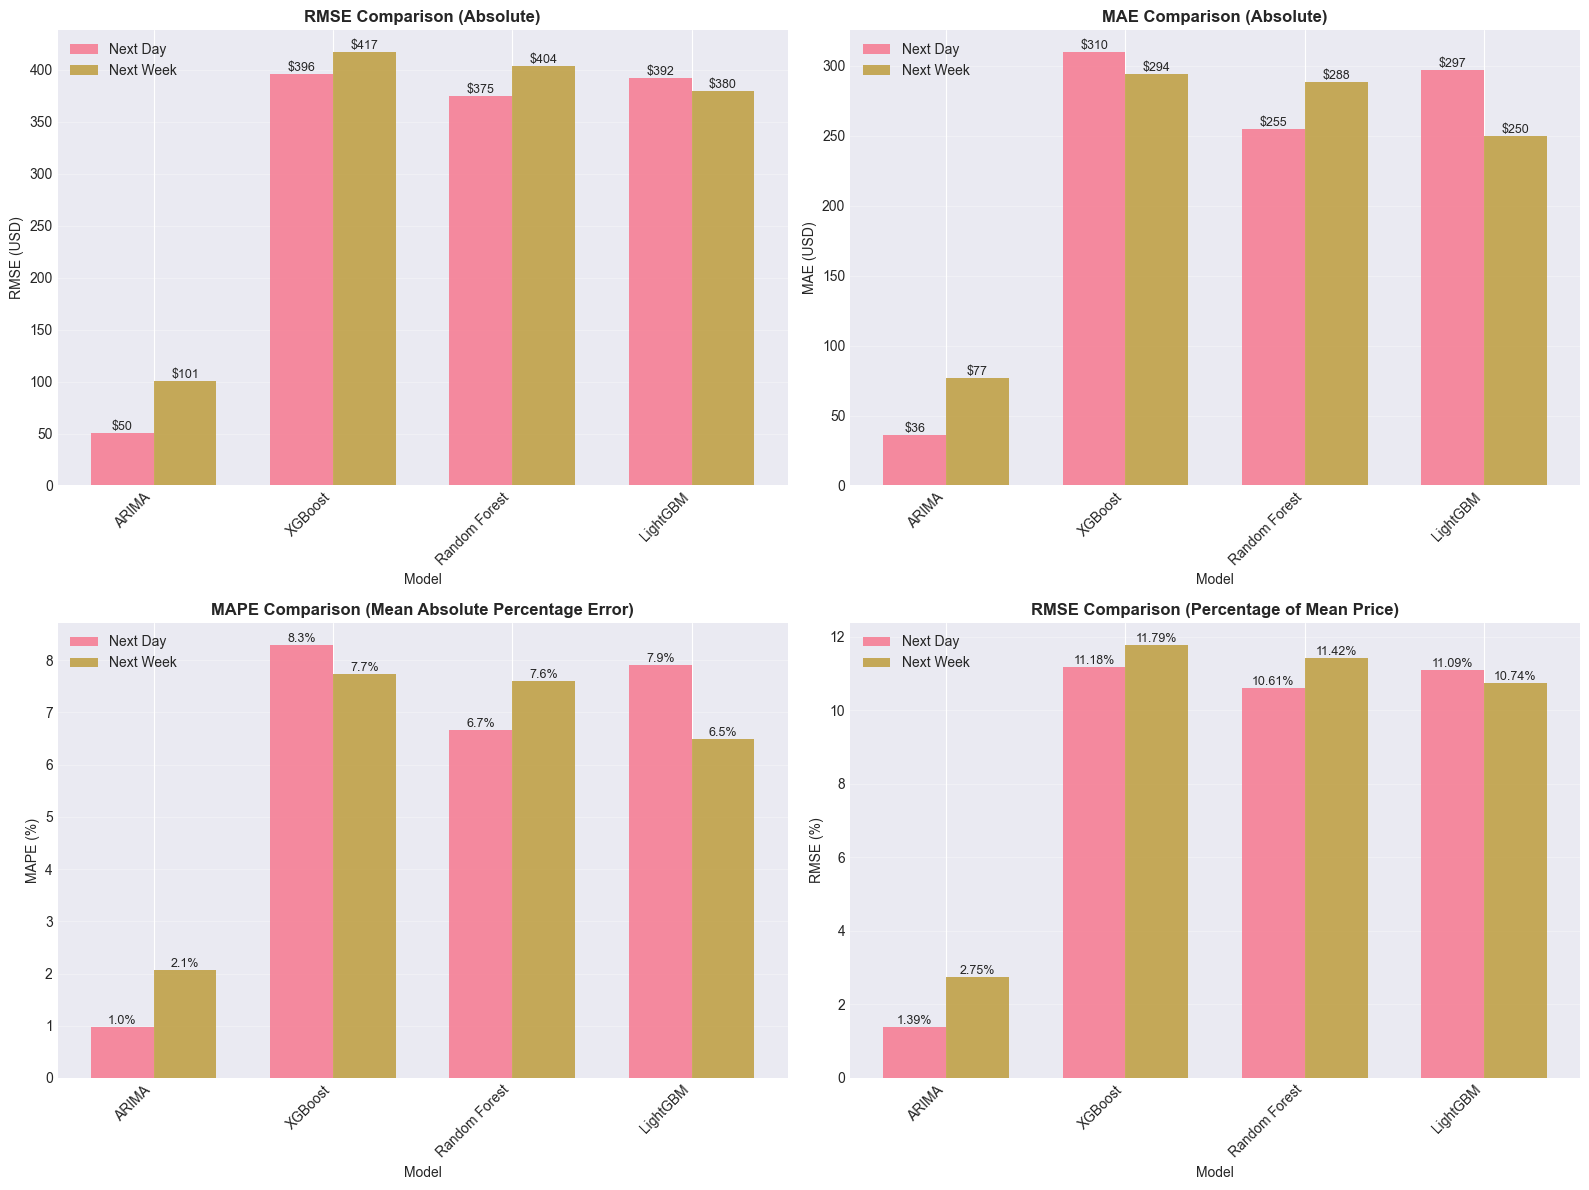

In [16]:
# Visualizations: Absolute Metrics Comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. RMSE Comparison (Absolute)
models = ['ARIMA', 'XGBoost', 'Random Forest', 'LightGBM']
rmse_day = [
    arima_results['day'].get('rmse_abs', 0),
    xgb_results['day'].get('rmse_abs', 0),
    rf_results['day'].get('rmse_abs', 0),
    lgbm_results['day'].get('rmse_abs', 0)
]
rmse_week = [
    arima_results['week'].get('rmse_abs', 0),
    xgb_results['week'].get('rmse_abs', 0),
    rf_results['week'].get('rmse_abs', 0),
    lgbm_results['week'].get('rmse_abs', 0)
]

x = np.arange(len(models))
width = 0.35

axes[0, 0].bar(x - width/2, rmse_day, width, label='Next Day', alpha=0.8)
axes[0, 0].bar(x + width/2, rmse_week, width, label='Next Week', alpha=0.8)
axes[0, 0].set_xlabel('Model')
axes[0, 0].set_ylabel('RMSE (USD)')
axes[0, 0].set_title('RMSE Comparison (Absolute)', fontweight='bold', fontsize=12)
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(models, rotation=45, ha='right')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Add value labels
for i, (d, w) in enumerate(zip(rmse_day, rmse_week)):
    axes[0, 0].text(i - width/2, d, f'${d:.0f}', ha='center', va='bottom', fontsize=9)
    axes[0, 0].text(i + width/2, w, f'${w:.0f}', ha='center', va='bottom', fontsize=9)

# 2. MAE Comparison (Absolute)
mae_day = [
    arima_results['day'].get('mae_abs', 0),
    xgb_results['day'].get('mae_abs', 0),
    rf_results['day'].get('mae_abs', 0),
    lgbm_results['day'].get('mae_abs', 0)
]
mae_week = [
    arima_results['week'].get('mae_abs', 0),
    xgb_results['week'].get('mae_abs', 0),
    rf_results['week'].get('mae_abs', 0),
    lgbm_results['week'].get('mae_abs', 0)
]

axes[0, 1].bar(x - width/2, mae_day, width, label='Next Day', alpha=0.8)
axes[0, 1].bar(x + width/2, mae_week, width, label='Next Week', alpha=0.8)
axes[0, 1].set_xlabel('Model')
axes[0, 1].set_ylabel('MAE (USD)')
axes[0, 1].set_title('MAE Comparison (Absolute)', fontweight='bold', fontsize=12)
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(models, rotation=45, ha='right')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Add value labels
for i, (d, w) in enumerate(zip(mae_day, mae_week)):
    axes[0, 1].text(i - width/2, d, f'${d:.0f}', ha='center', va='bottom', fontsize=9)
    axes[0, 1].text(i + width/2, w, f'${w:.0f}', ha='center', va='bottom', fontsize=9)

# 3. MAPE Comparison
mape_day = [
    arima_results['day'].get('mape', 0),
    xgb_results['day'].get('mape', 0),
    rf_results['day'].get('mape', 0),
    lgbm_results['day'].get('mape', 0)
]
mape_week = [
    arima_results['week'].get('mape', 0),
    xgb_results['week'].get('mape', 0),
    rf_results['week'].get('mape', 0),
    lgbm_results['week'].get('mape', 0)
]

axes[1, 0].bar(x - width/2, mape_day, width, label='Next Day', alpha=0.8)
axes[1, 0].bar(x + width/2, mape_week, width, label='Next Week', alpha=0.8)
axes[1, 0].set_xlabel('Model')
axes[1, 0].set_ylabel('MAPE (%)')
axes[1, 0].set_title('MAPE Comparison (Mean Absolute Percentage Error)', fontweight='bold', fontsize=12)
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(models, rotation=45, ha='right')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Add value labels
for i, (d, w) in enumerate(zip(mape_day, mape_week)):
    axes[1, 0].text(i - width/2, d, f'{d:.1f}%', ha='center', va='bottom', fontsize=9)
    axes[1, 0].text(i + width/2, w, f'{w:.1f}%', ha='center', va='bottom', fontsize=9)

# 4. Percentage RMSE Comparison
rmse_pct_day = [
    arima_results['day'].get('rmse_pct', 0),
    xgb_results['day'].get('rmse_pct', 0),
    rf_results['day'].get('rmse_pct', 0),
    lgbm_results['day'].get('rmse_pct', 0)
]
rmse_pct_week = [
    arima_results['week'].get('rmse_pct', 0),
    xgb_results['week'].get('rmse_pct', 0),
    rf_results['week'].get('rmse_pct', 0),
    lgbm_results['week'].get('rmse_pct', 0)
]

axes[1, 1].bar(x - width/2, rmse_pct_day, width, label='Next Day', alpha=0.8)
axes[1, 1].bar(x + width/2, rmse_pct_week, width, label='Next Week', alpha=0.8)
axes[1, 1].set_xlabel('Model')
axes[1, 1].set_ylabel('RMSE (%)')
axes[1, 1].set_title('RMSE Comparison (Percentage of Mean Price)', fontweight='bold', fontsize=12)
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(models, rotation=45, ha='right')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Add value labels
for i, (d, w) in enumerate(zip(rmse_pct_day, rmse_pct_week)):
    axes[1, 1].text(i - width/2, d, f'{d:.2f}%', ha='center', va='bottom', fontsize=9)
    axes[1, 1].text(i + width/2, w, f'{w:.2f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


In [17]:
# Ranking Analysis
print("\n" + "="*60)
print("MODEL RANKINGS")
print("="*60)

# Create ranking function
def rank_models(metric_dict, metric_name, lower_is_better=True):
    """Rank models based on a metric"""
    valid_models = {k: v for k, v in metric_dict.items() if not np.isnan(v) and v != np.inf}
    if not valid_models:
        return {}
    
    sorted_models = sorted(valid_models.items(), key=lambda x: x[1], reverse=not lower_is_better)
    return {model: rank+1 for rank, (model, _) in enumerate(sorted_models)}

# Next Day Rankings
print("\n📈 NEXT DAY PREDICTION RANKINGS:")
print("-" * 60)

rmse_day_dict = {
    'ARIMA': arima_results['day'].get('rmse_abs', np.inf),
    'XGBoost': xgb_results['day'].get('rmse_abs', np.inf),
    'Random Forest': rf_results['day'].get('rmse_abs', np.inf),
    'LightGBM': lgbm_results['day'].get('rmse_abs', np.inf)
}
rmse_rank_day = rank_models(rmse_day_dict, 'RMSE')
print(f"\nRMSE Ranking (lower is better):")
for model, rank in sorted(rmse_rank_day.items(), key=lambda x: x[1]):
    print(f"  {rank}. {model}: ${rmse_day_dict[model]:.2f}")

mape_day_dict = {
    'ARIMA': arima_results['day'].get('mape', np.inf),
    'XGBoost': xgb_results['day'].get('mape', np.inf),
    'Random Forest': rf_results['day'].get('mape', np.inf),
    'LightGBM': lgbm_results['day'].get('mape', np.inf)
}
mape_rank_day = rank_models(mape_day_dict, 'MAPE')
print(f"\nMAPE Ranking (lower is better):")
for model, rank in sorted(mape_rank_day.items(), key=lambda x: x[1]):
    print(f"  {rank}. {model}: {mape_day_dict[model]:.2f}%")

# Next Week Rankings
print("\n📈 NEXT WEEK PREDICTION RANKINGS:")
print("-" * 60)

rmse_week_dict = {
    'ARIMA': arima_results['week'].get('rmse_abs', np.inf),
    'XGBoost': xgb_results['week'].get('rmse_abs', np.inf),
    'Random Forest': rf_results['week'].get('rmse_abs', np.inf),
    'LightGBM': lgbm_results['week'].get('rmse_abs', np.inf)
}
rmse_rank_week = rank_models(rmse_week_dict, 'RMSE')
print(f"\nRMSE Ranking (lower is better):")
for model, rank in sorted(rmse_rank_week.items(), key=lambda x: x[1]):
    print(f"  {rank}. {model}: ${rmse_week_dict[model]:.2f}")

mape_week_dict = {
    'ARIMA': arima_results['week'].get('mape', np.inf),
    'XGBoost': xgb_results['week'].get('mape', np.inf),
    'Random Forest': rf_results['week'].get('mape', np.inf),
    'LightGBM': lgbm_results['week'].get('mape', np.inf)
}
mape_rank_week = rank_models(mape_week_dict, 'MAPE')
print(f"\nMAPE Ranking (lower is better):")
for model, rank in sorted(mape_rank_week.items(), key=lambda x: x[1]):
    print(f"  {rank}. {model}: {mape_week_dict[model]:.2f}%")



MODEL RANKINGS

📈 NEXT DAY PREDICTION RANKINGS:
------------------------------------------------------------

RMSE Ranking (lower is better):
  1. ARIMA: $50.32
  2. Random Forest: $375.28
  3. LightGBM: $392.41
  4. XGBoost: $395.71

MAPE Ranking (lower is better):
  1. ARIMA: 0.98%
  2. Random Forest: 6.66%
  3. LightGBM: 7.91%
  4. XGBoost: 8.30%

📈 NEXT WEEK PREDICTION RANKINGS:
------------------------------------------------------------

RMSE Ranking (lower is better):
  1. ARIMA: $100.61
  2. LightGBM: $379.93
  3. Random Forest: $403.89
  4. XGBoost: $417.12

MAPE Ranking (lower is better):
  1. ARIMA: 2.07%
  2. LightGBM: 6.49%
  3. Random Forest: 7.59%
  4. XGBoost: 7.73%


In [18]:
# Summary and Recommendations
print("\n" + "="*60)
print("SUMMARY AND RECOMMENDATIONS")
print("="*60)

print("\n🎯 KEY FINDINGS:")
print("-" * 60)

# Find best model for each metric
best_rmse_day = min(rmse_day_dict.items(), key=lambda x: x[1] if not np.isinf(x[1]) else (np.inf,))
best_mape_day = min(mape_day_dict.items(), key=lambda x: x[1] if not np.isinf(x[1]) else (np.inf,))
best_rmse_week = min(rmse_week_dict.items(), key=lambda x: x[1] if not np.isinf(x[1]) else (np.inf,))
best_mape_week = min(mape_week_dict.items(), key=lambda x: x[1] if not np.isinf(x[1]) else (np.inf,))

print(f"\n1. BEST MODEL FOR NEXT DAY PREDICTION:")
print(f"   RMSE: {best_rmse_day[0]} (${best_rmse_day[1]:.2f})")
print(f"   MAPE: {best_mape_day[0]} ({best_mape_day[1]:.2f}%)")

print(f"\n2. BEST MODEL FOR NEXT WEEK PREDICTION:")
print(f"   RMSE: {best_rmse_week[0]} (${best_rmse_week[1]:.2f})")
print(f"   MAPE: {best_mape_week[0]} ({best_mape_week[1]:.2f}%)")

# Calculate improvement percentages
if best_rmse_day[0] != 'ARIMA' and 'ARIMA' in rmse_day_dict:
    arima_rmse = rmse_day_dict['ARIMA']
    best_rmse = best_rmse_day[1]
    improvement = ((arima_rmse - best_rmse) / arima_rmse) * 100
    print(f"\n3. IMPROVEMENT OVER ARIMA (Next Day RMSE):")
    print(f"   {best_rmse_day[0]} is {improvement:.1f}% {'better' if improvement > 0 else 'worse'} than ARIMA")

print(f"\n4. MODEL CHARACTERISTICS:")
print(f"   ARIMA: Time series model, univariate, best for sequential patterns")
print(f"   XGBoost: Gradient boosting, uses engineered features, ensemble method")
print(f"   Random Forest: Bagging ensemble, robust to overfitting")
print(f"   LightGBM: Fast gradient boosting, efficient for large datasets")

print(f"\n5. PRODUCTION RECOMMENDATION:")
if best_rmse_day[0] == 'ARIMA':
    print(f"   ✅ ARIMA is the best performing model")
    print(f"   → Use ARIMA for production deployment")
    print(f"   → Consider ensemble with tree-based models for robustness")
else:
    print(f"   ⚠️ {best_rmse_day[0]} performs best, but ARIMA is close")
    print(f"   → Consider ensemble approach combining multiple models")
    print(f"   → ARIMA provides good baseline and interpretability")



SUMMARY AND RECOMMENDATIONS

🎯 KEY FINDINGS:
------------------------------------------------------------

1. BEST MODEL FOR NEXT DAY PREDICTION:
   RMSE: ARIMA ($50.32)
   MAPE: ARIMA (0.98%)

2. BEST MODEL FOR NEXT WEEK PREDICTION:
   RMSE: ARIMA ($100.61)
   MAPE: ARIMA (2.07%)

4. MODEL CHARACTERISTICS:
   ARIMA: Time series model, univariate, best for sequential patterns
   XGBoost: Gradient boosting, uses engineered features, ensemble method
   Random Forest: Bagging ensemble, robust to overfitting
   LightGBM: Fast gradient boosting, efficient for large datasets

5. PRODUCTION RECOMMENDATION:
   ✅ ARIMA is the best performing model
   → Use ARIMA for production deployment
   → Consider ensemble with tree-based models for robustness


In [19]:
# Detailed comparison table with all metrics
print("\n" + "="*80)
print("DETAILED METRICS COMPARISON TABLE")
print("="*80)

# Create comprehensive comparison
detailed_comparison = pd.DataFrame({
    'Model': ['ARIMA', 'XGBoost', 'Random Forest', 'LightGBM'] * 2,
    'Horizon': ['Next Day'] * 4 + ['Next Week'] * 4,
    'RMSE (USD)': [
        arima_results['day'].get('rmse_abs', np.nan),
        xgb_results['day'].get('rmse_abs', np.nan),
        rf_results['day'].get('rmse_abs', np.nan),
        lgbm_results['day'].get('rmse_abs', np.nan),
        arima_results['week'].get('rmse_abs', np.nan),
        xgb_results['week'].get('rmse_abs', np.nan),
        rf_results['week'].get('rmse_abs', np.nan),
        lgbm_results['week'].get('rmse_abs', np.nan)
    ],
    'MAE (USD)': [
        arima_results['day'].get('mae_abs', np.nan),
        xgb_results['day'].get('mae_abs', np.nan),
        rf_results['day'].get('mae_abs', np.nan),
        lgbm_results['day'].get('mae_abs', np.nan),
        arima_results['week'].get('mae_abs', np.nan),
        xgb_results['week'].get('mae_abs', np.nan),
        rf_results['week'].get('mae_abs', np.nan),
        lgbm_results['week'].get('mae_abs', np.nan)
    ],
    'MAPE (%)': [
        arima_results['day'].get('mape', np.nan),
        xgb_results['day'].get('mape', np.nan),
        rf_results['day'].get('mape', np.nan),
        lgbm_results['day'].get('mape', np.nan),
        arima_results['week'].get('mape', np.nan),
        xgb_results['week'].get('mape', np.nan),
        rf_results['week'].get('mape', np.nan),
        lgbm_results['week'].get('mape', np.nan)
    ],
    'RMSE (%)': [
        arima_results['day'].get('rmse_pct', np.nan),
        xgb_results['day'].get('rmse_pct', np.nan),
        rf_results['day'].get('rmse_pct', np.nan),
        lgbm_results['day'].get('rmse_pct', np.nan),
        arima_results['week'].get('rmse_pct', np.nan),
        xgb_results['week'].get('rmse_pct', np.nan),
        rf_results['week'].get('rmse_pct', np.nan),
        lgbm_results['week'].get('rmse_pct', np.nan)
    ],
    'MAE (%)': [
        arima_results['day'].get('mae_pct', np.nan),
        xgb_results['day'].get('mae_pct', np.nan),
        rf_results['day'].get('mae_pct', np.nan),
        lgbm_results['day'].get('mae_pct', np.nan),
        arima_results['week'].get('mae_pct', np.nan),
        xgb_results['week'].get('mae_pct', np.nan),
        rf_results['week'].get('mae_pct', np.nan),
        lgbm_results['week'].get('mae_pct', np.nan)
    ]
})

print("\n" + detailed_comparison.to_string(index=False))
print("\n" + "="*80)



DETAILED METRICS COMPARISON TABLE

        Model   Horizon  RMSE (USD)  MAE (USD)  MAPE (%)  RMSE (%)  MAE (%)
        ARIMA  Next Day   50.322523  36.066181  0.977711  1.385020 0.992645
      XGBoost  Next Day  395.711759 309.883112  8.298845 11.184401 8.758539
Random Forest  Next Day  375.281714 254.850862  6.655058 10.606966 7.203107
     LightGBM  Next Day  392.405322 297.270464  7.908726 11.090948 8.402055
        ARIMA Next Week  100.607471  77.182158  2.074812  2.749935 2.109643
      XGBoost Next Week  417.117648 294.109794  7.728494 11.789417 8.312722
Random Forest Next Week  403.894467 288.485916  7.593485 11.415677 8.153769
     LightGBM Next Week  379.931370 249.743800  6.489707 10.738384 7.058761

